# OCR, but Grayscale in 3 channels.

In [2]:
! pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ypjnz5c4
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ypjnz5c4
  Resolved https://github.com/tensorflow/docs to commit 3ad57a2dd8c8878c47e6e7e7cdfbe43d3c528d34
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=183273 sha256=2eee9bbbeb9e6c6b680ccd4f45aeb3d38b954392c8973569bdee75fb5a670f40
  Stored in directory: /tmp/pip-ephem-wheel-cache-1x_k933x/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


Library Import

In [3]:
import numpy as np
import zipfile
import gc
import cv2
import math
import warnings
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import imageio
import torch.nn.functional as F
import PIL
import imutils
import torch.optim as optim
import tensorflow_docs.vis.embed as embed

from sklearn.metrics import confusion_matrix, roc_curve
from torch.utils.data import Dataset
from collections import deque
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from google.colab.patches import cv2_imshow
from imutils.contours import sort_contours

print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4036942216865179694
xla_global_id: -1
]


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Preprocessing

In [34]:
def convert_image_from_grayscale_to_color(torch_image):
  image = torch.cat([torch_image, torch_image, torch_image], axis = 0)
  return image

In [36]:
mnist_train_transform = transforms.Compose([
    transforms.RandomAffine(degrees = 10, translate = (0.1, 0.1), shear = 2),
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    transforms.Lambda(convert_image_from_grayscale_to_color),
    transforms.Normalize((0.5, ), (0.5, )) # Scale to -1 to 1
])

mnist_validation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(convert_image_from_grayscale_to_color),
    transforms.Normalize((0.5, ), (0.5, )),
])

mnist_trainset = torchvision.datasets.MNIST('mnist', 
                                      train = True, 
                                      download = True,
                                      transform = mnist_train_transform)

mnist_valset = torchvision.datasets.MNIST('mnist', 
                                      train = False, 
                                      download = True,
                                      transform = mnist_validation_transform)

print(mnist_trainset.data.shape)
print(mnist_valset.data.shape)

print(mnist_trainset.targets.shape)
print(mnist_valset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


In [37]:
batch_size = 128

mnist_train_loader = torch.utils.data.DataLoader(
    mnist_trainset, 
    batch_size = batch_size, 
    shuffle = True,
)

mnist_validation_loader = torch.utils.data.DataLoader(
    mnist_valset, 
    batch_size = batch_size, 
    shuffle = False
)

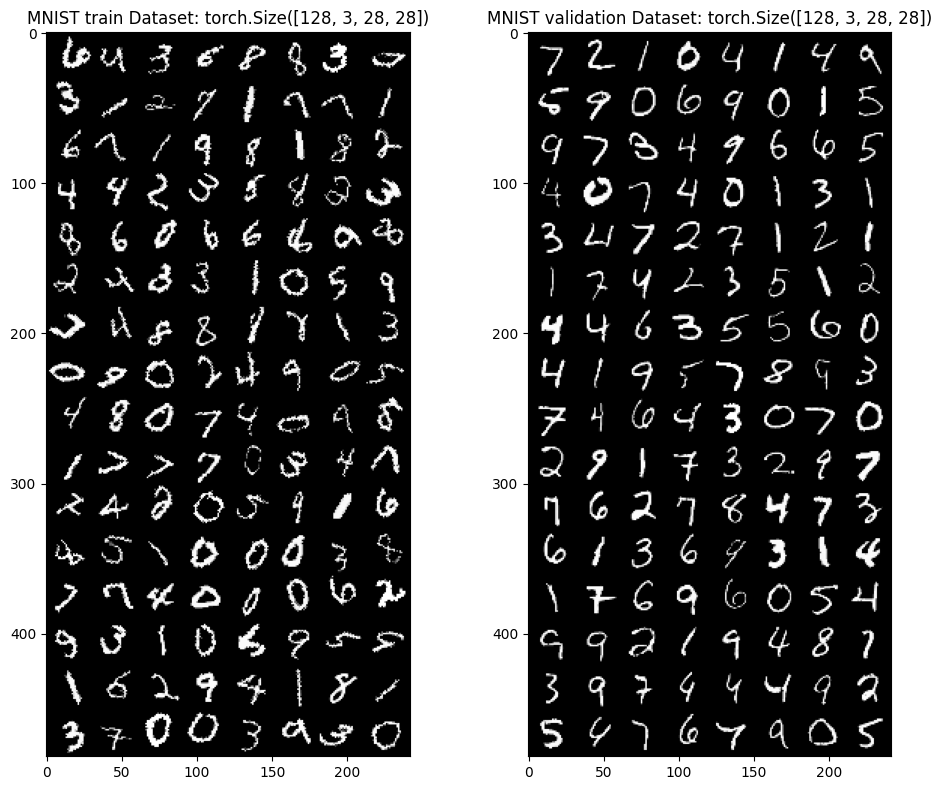

In [38]:
def plot_images_in_grid(title, images, labels, figsize = (5, 5), MIN_INDEX_PLOT = 0, MAX_INDEX_PLOT = 20):
  plt.figure(figsize = (5, 5))
  plt.suptitle(title)
  for index in range(MIN_INDEX_PLOT, MAX_INDEX_PLOT):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.text(x = 10, y = 0.5, s = labels[index], fontsize = 10, bbox = dict(facecolor = 'white'))
    plt.imshow(images[index], cmap = 'gray')

def visualize_grid(images_in_batch):
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  sample_image_batch, sample_labels_batch = next(iter_loader)

  plt.title(f"{title} Dataset: {sample_image_batch.shape}")
  visualize_grid(sample_image_batch)

def debug_dataloader(data_loader, title, expected_batch_size):
   print(f"Debugging {title}...")
   iter_loader = iter(data_loader)
   total_exact_same_batches = 0
   different_batches = []
   print(list(data_loader))

plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)

visualize_dataloader(mnist_train_loader, "MNIST train")

plt.subplot(1, 2, 2)
visualize_dataloader(mnist_validation_loader, "MNIST validation")

plt.tight_layout()
plt.show()

## Data Modelling

Make model architecture.

In [39]:
class MNISTColorModel(nn.Module):
  def __init__(self):
    super().__init__()

    # We calculate this formula for padding.
    # NOTES: Filter_size = kernel_size
    # In this case, we use same padding, the formula is: [(filter_size  - 1) / 2] ( Same Padding--> input size = output size).

    # Formula of feature map size: [(input_size - filter_size + 2(padding) / stride) + 1]
    # Output after conv1: [(28 - 3 + 2 (1) / 1) + 1] = 28
    # Output after MaxPool1 = 28 / 2 = 14
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1, bias = True), 
        nn.ReLU(), 
        nn.MaxPool2d(2,2))

    # To attain same padding: we use features of 
    # Padding: [(3 - 1) / 2] = 1
    # Output after conv2: [(14 - 3 + 2 (1) / 1) + 1] = 14
    # Output after MaxPool2: 14 / 2 = 7
    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, bias = True), 
      nn.ReLU(), 
      nn.MaxPool2d(2,2)
    )

    self.avg_pool2d = nn.AdaptiveAvgPool2d(output_size = (3, 3))

    # Flatten the layers.
    # 32 = number of filters
    # 7 = size of max pool 2 feature map output.
    self.fc1 = nn.Sequential(
      nn.Flatten(), 
      nn.Linear(64*3*3,32), 
      nn.ReLU(), 
      nn.Linear(32,16),
      nn.ReLU()
    )
    self.fc2 = nn.Sequential(
      nn.Linear(16,8), 
      nn.ReLU(),
      nn.Linear(8,10)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.avg_pool2d(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

mnist_model = MNISTColorModel().to(device)
mnist_model

MNISTColorModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool2d): AdaptiveAvgPool2d(output_size=(3, 3))
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=576, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=10, bias=True)
  )
)

## Model Training

In [40]:
loss_func = nn.CrossEntropyLoss()
mnist_model = MNISTColorModel().to(device)

optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)

In [42]:
def validate_model(model, val_batches, device):
  with torch.no_grad():
    correct = 0
    total = 0
    for batch in val_batches:
      data, labels = batch
      
      # Move the data to GPU.
      data = data.to(device)  
      labels = labels.to(device)

      # Perform feed forward to the model.
      outputs = model(data)

      # Get the prediction of each output. (Softmax)
      _, predicted = torch.max(outputs.data, 1)

      # Get the label size to total variable. 
      total += labels.size(0)

      # Keep a running total .
      correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

n_epochs = 15

epochs_log = []
loss_log = []
iterations = []

def save_model(model, optimizer, filename = "model.pth.tar"):
  print("Saving model...")
  checkpoint = {
      "model_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict()
  }
  torch.save(checkpoint, filename)
  print("Finished saving model!")

directory_path = "./drive/MyDrive/Models"

for epoch in range(0, n_epochs):
  for train_iteration, batch in enumerate(mnist_train_loader):
    images_in_batch, labels_in_batch = batch
    images_in_batch = images_in_batch.to(device)
    labels_in_batch = labels_in_batch.to(device)

    optimizer.zero_grad()

    outputs_in_batch = mnist_model(
        images_in_batch,
    )

    loss = loss_func(outputs_in_batch, labels_in_batch)
    # outputs_in_batch.backward(labels_in_batch, retain_graph = True)

    loss.backward()
    optimizer.step()

    if train_iteration % 10 == 0:
      print(f"Current Epoch: {epoch}, iteration = {train_iteration}, with current loss: {loss.item()}")
      loss_log.append(loss.item())
      iterations.append(train_iteration)
      
  accuracy = validate_model(mnist_model, mnist_validation_loader, device)
  print(f"Current Epoch: {epoch}, with average accuracy: {accuracy}%")
  save_model(mnist_model, optimizer, filename = f"{directory_path}/ocr_color_mnist_model.pth.tar")

Current Epoch: 0, iteration = 0, with current loss: 1.0202337503433228
Current Epoch: 0, iteration = 10, with current loss: 0.9906487464904785
Current Epoch: 0, iteration = 20, with current loss: 1.0087120532989502
Current Epoch: 0, iteration = 30, with current loss: 1.122652530670166
Current Epoch: 0, iteration = 40, with current loss: 0.9552657008171082
Current Epoch: 0, iteration = 50, with current loss: 1.0206631422042847
Current Epoch: 0, iteration = 60, with current loss: 0.9962487816810608
Current Epoch: 0, iteration = 70, with current loss: 1.0590598583221436
Current Epoch: 0, iteration = 80, with current loss: 0.9408428072929382
Current Epoch: 0, iteration = 90, with current loss: 0.9996298551559448
Current Epoch: 0, iteration = 100, with current loss: 0.8429117798805237
Current Epoch: 0, iteration = 110, with current loss: 0.9894843697547913
Current Epoch: 0, iteration = 120, with current loss: 0.814699113368988
Current Epoch: 0, iteration = 130, with current loss: 0.89574253